In [133]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn import metrics
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from xgboost import XGBRanker
from sklearn.linear_model import LassoCV
from sklearn.model_selection import GridSearchCV
sns.set()
import warnings
warnings.filterwarnings("ignore")
import torch.nn as nn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from adapt.instance_based import KLIEP


In [134]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.cross_decomposition import CCA
from sklearn.cross_decomposition import PLSCanonical
from sklearn.cross_decomposition import PLSSVD
from operator import itemgetter
def softmax(x):
    return(np.exp(x)/np.exp(x).sum())

def my_custom_loss_func_exp(y_true, y_pred):
    return spearmanr(np.exp(y_true), np.exp(y_pred)).correlation  

def my_custom_loss_func(y_true, y_pred):
    #y_pred = np.exp(np.array(y_pred))
    return spearmanr(y_true, y_pred).correlation

def loss(y_true,y_pred):
    return np.corrcoef(y_true,y_pred)[0][1]

def select_columns(X, y, test_size = 0.33, size_features= 30, state = 100):
    dic = dict({})
    for i in range(100,100+state):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=i)
        X_train = np.array(X_train)
        X_test = np.array(X_test)
        all_corr = []
        for i in range(X_train.shape[1]):
            cor = my_custom_loss_func(y_train,X_train[:,i])
            all_corr.append(cor)
            
        all_corr = np.array(all_corr)
        cols = np.argsort(all_corr)[::-1]
        cols_keep = cols[:size_features]
        for i in cols_keep:
            if(i in dic):
                dic[i]+=1
            else:
                dic[i] = 1
   
    s = sorted(dic.items(), key=itemgetter(1),reverse=1)
    print(s)
    cols_keep = []
    for i in range(size_features):
        cols_keep.append(s[i][0])
    return np.array(cols_keep)

def evaluate_model_mean(X, y, model, stratify ,  test_size=0.33, loss = my_custom_loss_func, state = 100, size_features = 30):
    
    score = []
    for i in range(state):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,random_state=i, stratify=stratify)
        
        '''
        mask = (X_test['COUNTRY']==-1)
        X_test_FR = X_test[mask].copy()
        y_train = np.array(y_train)
        y_test_FR = np.array(y_test)[np.array(mask)].copy()
        
        
        mask = (X_test['COUNTRY']==1)
        X_test_DE = X_test[mask].copy()
        y_test_DE = np.array(y_test)[np.array(mask)].copy()
        '''
    
        X_train = np.array(X_train)
        X_test = np.array(X_test)
        '''
        X_test_FR = np.array(X_test_FR)
        X_test_DE = np.array(X_test_DE)
        '''
        #model_pca = PCA(n_components=X_train.shape[1])
        #model_pca.fit(X_train)
        #X_train = model_pca.transform(X_train)
        #X_test = model_pca.transform(X_test)
                
        
        model.fit(X_train,y_train)
        train_score = loss(y_train, model.predict(X_train))
        y_predict = model.predict(X_test)
        test_score = loss(y_test , y_predict.reshape(-1))
        '''
        y_predict_FR = model.predict(X_test_FR)
        test_score_FR = loss(np.array(y_test_FR) , y_predict_FR.reshape(-1))
        
        y_predict_DE = model.predict(X_test_DE)
        test_score_DE = loss(np.array(y_test_DE) , y_predict_DE.reshape(-1))
        '''
        score.append([test_score])#,test_score_FR,test_score_DE])
        
    return np.mean(np.array(score),axis=0)


def evaluate_model_mean_lgb(X, y, model, stratify ,  test_size=0.33, loss = my_custom_loss_func, state = 100, size_features = 30):

    score = []
    for i in range(state):
        import lightgbm as lgbm

        X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X, y, test_size=0.3,random_state=i, stratify=stratify)
        X_train_m, X_val_m, y_train_m, y_val_m = train_test_split(X_train_m, y_train_m, test_size=0.2,random_state=i)

        lgbm_parameters ={
        'n_estimators': 10000,
        'learning_rate': 0.0941884136011224,
        'num_leaves': 180,
        'max_depth': 12,
        'min_data_in_leaf': 200,
        'lambda_l1': 0.01,
        'lambda_l2': 1,
        'min_gain_to_split': 8.756413243587552,
        'bagging_fraction': 0.6000000000000001,
        'bagging_freq': 1,
        'feature_fraction': 0.5}

        model = lgbm.LGBMRegressor(objective="regression", **lgbm_parameters)
        model.fit(
            X_train_m,
            y_train_m,
            eval_set=[(X_val_m,y_val_m)],
            eval_metric="l1",
            early_stopping_rounds=100
        )

        X_train_m = np.array(X_train_m)
        X_test_m = np.array(X_test_m)
        
        train_score = loss(y_train_m, model.predict(X_train_m))
        y_predict = model.predict(X_test_m)
        test_score = loss(y_test_m , y_predict.reshape(-1))
        
        score.append([test_score])
        
    return np.mean(np.array(score),axis=0)


def evaluate_model_mean_all(X, y, model, stratify ,  test_size=0.33, loss = my_custom_loss_func, state = 100, size_features = 30):
    
    score = []
    for i in range(state):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,random_state=i, stratify=stratify)
        
        
        mask = (X_test['COUNTRY']==-1)
        X_test_FR = X_test[mask].copy()
        y_train = np.array(y_train)
        y_test_FR = np.array(y_test)[np.array(mask)].copy()
        
        
        mask = (X_test['COUNTRY']==1)
        X_test_DE = X_test[mask].copy()
        y_test_DE = np.array(y_test)[np.array(mask)].copy()
      
    
        X_train = np.array(X_train)
        X_test = np.array(X_test)
      
        X_test_FR = np.array(X_test_FR)
        X_test_DE = np.array(X_test_DE)
      
        #model_pca = PCA(n_components=X_train.shape[1])
        #model_pca.fit(X_train)
        #X_train = model_pca.transform(X_train)
        #X_test = model_pca.transform(X_test)
                
        
        model.fit(X_train,y_train)
        train_score = loss(y_train, model.predict(X_train))
        y_predict = model.predict(X_test)
        test_score = loss(y_test , y_predict.reshape(-1))
        
        y_predict_FR = model.predict(X_test_FR)
        test_score_FR = loss(np.array(y_test_FR) , y_predict_FR.reshape(-1))
        
        y_predict_DE = model.predict(X_test_DE)
        test_score_DE = loss(np.array(y_test_DE) , y_predict_DE.reshape(-1))
      
        score.append([test_score,test_score_FR,test_score_DE])
        
    return np.mean(np.array(score),axis=0)

In [135]:
path = 'data/'
X_train = pd.read_csv( path + 'X_train.csv')
Y_train = pd.read_csv(path + 'Y_train.csv')
X_test = pd.read_csv(path + 'X_test.csv')

- ID: Unique row identifier, associated with a day (DAY_ID) and a country (COUNTRY),
- DAY_ID: Day identifier - dates have been anonymized, but all data corresponding to a specific day is consistent,
- COUNTRY: Country identifier - DE = Germany, FR = France, 

and then contains daily commodity price variations:

- GAS_RET: European gas,
- COAL_RET: European coal,
- CARBON_RET: Carbon emissions futures,

weather measures (daily, in the country x):

- x_TEMP: Temperature,
- x_RAIN: Rainfall,
- x_WIND: Wind,

energy production measures (daily, in the country x),

- x_GAS: Natural gas,
- x_COAL: Hard coal,
- x_HYDRO: Hydro reservoir,
- x_NUCLEAR: Daily nuclear production,
- x_SOLAR: Photovoltaic,
- x_WINDPOW: Wind power,
- x_LIGNITE: Lignite,

and electricity use metrics (daily, in the country x),

- x_CONSUMPTON: Total electricity consumption,
- x_RESIDUAL_LOAD: Electricity consumption after using all renewable energies,
- x_NET_IMPORT: Imported electricity from Europe,
- x_NET_EXPORT: Exported electricity to Europe,
- DE_FR_EXCHANGE: Total daily electricity exchange between Germany and France,
- FR_DE_EXCHANGE: Total daily electricity exchange between France and Germany.

Output data sets are composed of two columns:

- ID: Unique row identifier - corresponding to the input identifiers,
- TARGET: Daily price variation for futures of 24H electricity baseload.

In [136]:
data = pd.merge(X_train, Y_train, on=['ID'])
all_data = data.copy()
all_data['train'] = 1
all_data = pd.concat([all_data,X_test])
all_data['TARGET'] = all_data['TARGET'].fillna(0)
all_data['train'] = all_data['train'].fillna(0)

In [137]:
from sklearn.impute import KNNImputer

def regress_var(df, x_columns, y_column, model, out = True):
    temp = df.dropna().copy()
    X = np.array(temp[x_columns])
    y = np.array(temp[y_column])
    model.fit(X,y)
    if(out):
        print("Model score", model.score(X,y))
    return df.apply(lambda row: model.predict(np.array(row[x_columns]).reshape(-1,len(x_columns)))[0] if(np.isnan(row[y_column])) else row[y_column], axis=1)


def clean_knn(all_data_clean, k =5 ):
    imputer = KNNImputer(n_neighbors=k)
    remove_columns = ['ID','DAY_ID','TARGET','train']
    keep = all_data_clean.columns.difference(remove_columns)
    all_data_clean[keep] = imputer.fit_transform(all_data_clean[keep])
    return all_data_clean
    
def clean_regression(all_data_clean):
    
    #all_data_clean['DE_FR_EXCHANGE'] = all_data_clean['DE_FR_EXCHANGE'].fillna(0)
    #all_data_clean['FR_DE_EXCHANGE'] = all_data_clean['FR_DE_EXCHANGE'].fillna(0)
    
    all_data_clean['DE_FR_EXCHANGE'] = all_data_clean['DE_FR_EXCHANGE'].fillna(all_data_clean['DE_FR_EXCHANGE'].mean(numeric_only=True))
    all_data_clean['FR_DE_EXCHANGE'] = all_data_clean['FR_DE_EXCHANGE'].fillna(all_data_clean['FR_DE_EXCHANGE'].mean(numeric_only=True))
    
    x_columns = ['DE_FR_EXCHANGE']
    y_column = 'DE_NET_EXPORT'
    all_data_clean[y_column] = regress_var(all_data_clean, x_columns, y_column, LinearRegression(), out=True)
    all_data_clean['DE_NET_IMPORT'] = - all_data_clean['DE_NET_EXPORT']
    
    x_columns = ['FR_DE_EXCHANGE']
    y_column = 'FR_NET_EXPORT'
    all_data_clean[y_column] = regress_var(all_data_clean, x_columns, y_column, LinearRegression(), out=True)
    all_data_clean['FR_NET_IMPORT'] = - all_data_clean['FR_NET_EXPORT']
    
    all_data_clean = all_data_clean.fillna(all_data_clean.mean(numeric_only=True))
    
    return all_data_clean

def remove_features(all_data_clean):
    
    all_data_clean = all_data_clean.drop(['DE_FR_EXCHANGE', 'FR_NET_IMPORT','DE_NET_IMPORT'],axis=1)
    all_data_clean['FR_NET_EXPORT'] -= all_data_clean['FR_DE_EXCHANGE']
    all_data_clean['DE_NET_EXPORT'] += all_data_clean['FR_DE_EXCHANGE']
    
    
    all_data_clean['DE_CONSUMPTION_RENEWABLE'] = all_data_clean['DE_CONSUMPTION'] - all_data_clean['DE_RESIDUAL_LOAD']
    all_data_clean['FR_CONSUMPTION_RENEWABLE'] = all_data_clean['FR_CONSUMPTION'] - all_data_clean['FR_RESIDUAL_LOAD']

    
    #all_data_clean = all_data_clean.rename(columns={'DE_CONSUMPTION':'DE_CONSUMPTION_RENEWABLE', 'FR_CONSUMPTION':'FR_CONSUMPTION_RENEWABLE' })
    
    all_data_clean['DE_FLOW_GAS'] = all_data_clean['DE_GAS']*all_data_clean['GAS_RET']
    all_data_clean['DE_FLOW_COAL'] = all_data_clean['DE_COAL']*all_data_clean['COAL_RET']
    all_data_clean['DE_FLOW_LIGNITE'] = all_data_clean['DE_LIGNITE']*all_data_clean['CARBON_RET']


    all_data_clean['FR_FLOW_GAS'] = all_data_clean['FR_GAS']*all_data_clean['GAS_RET']
    all_data_clean['FR_FLOW_COAL'] = all_data_clean['FR_COAL']*all_data_clean['COAL_RET']
    
    return all_data_clean

def add_clusters(k, all_data_clean,cols,c):
    from sklearn.cluster import KMeans
    X_season = all_data_clean[cols]
    #all_data_clean = all_data_clean.drop(cols,axis=1)
    kmeans = KMeans(n_clusters=k,random_state = 0).fit(np.array(X_season))
    all_data_clean[c] = kmeans.predict(np.array(X_season))
    all_data_clean = pd.get_dummies(all_data_clean, columns=[c])
    return all_data_clean


def replace_outliers(all_data_clean, cols, threshold = 3):
    for c in cols :
        upper_limit = all_data_clean[c].mean() + threshold*all_data_clean[c].std()
        lower_limit = all_data_clean[c].mean() - threshold*all_data_clean[c].std()    
        all_data_clean[c] = np.where(
            (all_data_clean[c]>upper_limit) & (all_data_clean['train']==0),
            upper_limit,
            np.where(
                (all_data_clean[c]<lower_limit) & (all_data_clean['train']==0),
                lower_limit,
                all_data_clean[c]
            ))
    return all_data_clean

def remove_outliers(all_data_clean, cols, threshold = 3):
    for c in cols :
        upper_limit = all_data_clean[c].mean() + threshold*all_data_clean[c].std()
        lower_limit = all_data_clean[c].mean() - threshold*all_data_clean[c].std()    
        all_data_clean[c] = np.where(
            (all_data_clean[c]>upper_limit) & (all_data_clean['train']==1),
            np.nan,
            np.where(
                (all_data_clean[c]<lower_limit) & (all_data_clean['train']==1),
                np.nan,
                all_data_clean[c]
            ))
    all_data_clean = all_data_clean.dropna()
    return all_data_clean

In [138]:
all_data_clean = all_data.copy()
all_data_clean['COUNTRY'] = all_data_clean['COUNTRY'].apply(lambda x: 0 if x =='FR' else 1)


#all_data_clean = all_data_clean.apply(lambda x: x.fillna(x.median()),axis=0)

#clean
all_data_clean = clean_regression(all_data_clean)

#remove features
all_data_clean = remove_features(all_data_clean)


columns = ['FR_DE_EXCHANGE', 'DE_NET_EXPORT',
       'FR_NET_EXPORT', 'DE_GAS', 'FR_GAS', 'DE_COAL', 'FR_COAL', 'DE_HYDRO',
       'FR_HYDRO', 'DE_NUCLEAR', 'FR_NUCLEAR', 'DE_SOLAR', 'FR_SOLAR',
       'DE_WINDPOW', 'FR_WINDPOW', 'DE_LIGNITE', 'DE_RESIDUAL_LOAD',
       'FR_RESIDUAL_LOAD', 'GAS_RET', 'COAL_RET', 'CARBON_RET']

#all_data_clean = remove_outliers(all_data_clean, columns)

#all_data_clean = replace_outliers(all_data_clean, columns)

'''
cols = ['DE_RAIN','FR_RAIN','DE_WIND','FR_WIND','DE_TEMP','FR_TEMP']
all_data_clean = add_clusters(4,all_data_clean,cols,'season')



cols = [ 'FR_HYDRO', 'FR_NUCLEAR', 'FR_SOLAR', 'FR_WINDPOW']
all_data_clean = add_clusters(4,all_data_clean,cols,'E_FR')


cols = [ 'DE_HYDRO', 'DE_NUCLEAR', 'DE_SOLAR', 'DE_WINDPOW', 'DE_LIGNITE']
all_data_clean = add_clusters(4,all_data_clean,cols,'E_DE')


cols = ['FR_GAS', 'FR_COAL','FR_RESIDUAL_LOAD']
all_data_clean = add_clusters(4,all_data_clean,cols,'N_FR')

cols = ['DE_GAS', 'DE_COAL','DE_RESIDUAL_LOAD']
all_data_clean = add_clusters(4,all_data_clean,cols,'N_DE')

'''

Model score 0.49328444244850245
Model score 0.4424460230408356


"\ncols = ['DE_RAIN','FR_RAIN','DE_WIND','FR_WIND','DE_TEMP','FR_TEMP']\nall_data_clean = add_clusters(4,all_data_clean,cols,'season')\n\n\n\ncols = [ 'FR_HYDRO', 'FR_NUCLEAR', 'FR_SOLAR', 'FR_WINDPOW']\nall_data_clean = add_clusters(4,all_data_clean,cols,'E_FR')\n\n\ncols = [ 'DE_HYDRO', 'DE_NUCLEAR', 'DE_SOLAR', 'DE_WINDPOW', 'DE_LIGNITE']\nall_data_clean = add_clusters(4,all_data_clean,cols,'E_DE')\n\n\ncols = ['FR_GAS', 'FR_COAL','FR_RESIDUAL_LOAD']\nall_data_clean = add_clusters(4,all_data_clean,cols,'N_FR')\n\ncols = ['DE_GAS', 'DE_COAL','DE_RESIDUAL_LOAD']\nall_data_clean = add_clusters(4,all_data_clean,cols,'N_DE')\n\n"

In [139]:

all_data_clean["FR_PRODUCTION"] = all_data_clean['FR_GAS'] + all_data_clean['FR_COAL'] + all_data_clean['FR_HYDRO'] + all_data_clean['FR_NUCLEAR'] + all_data_clean['FR_SOLAR'] + all_data_clean['FR_WINDPOW']
all_data_clean["DE_PRODUCTION"] = all_data_clean['DE_GAS'] + all_data_clean['DE_COAL'] + all_data_clean['DE_HYDRO'] + all_data_clean['DE_NUCLEAR'] + all_data_clean['DE_SOLAR'] + all_data_clean['DE_WINDPOW'] + all_data_clean['DE_LIGNITE']

all_data_clean['FR_NEED'] = all_data_clean["FR_CONSUMPTION"] - all_data_clean['FR_PRODUCTION']  
all_data_clean['DE_NEED'] = all_data_clean["DE_CONSUMPTION"] - all_data_clean['DE_PRODUCTION'] 

all_data_clean['FR_NEED_RATIO'] =   all_data_clean['FR_CONSUMPTION'] / all_data_clean["FR_PRODUCTION"]
all_data_clean['DE_NEED_RATIO'] =  all_data_clean['DE_CONSUMPTION'] / all_data_clean["DE_PRODUCTION"] 

all_data_clean['FR_NEED_RATIO_1'] =   all_data_clean['FR_NEED'] / all_data_clean["FR_PRODUCTION"]
all_data_clean['DE_NEED_RATIO_1'] =  all_data_clean['DE_NEED'] / all_data_clean["DE_PRODUCTION"] 


all_data_clean['FR_NEED_RATIO_2'] =   all_data_clean["FR_PRODUCTION"] / all_data_clean['FR_NEED']
all_data_clean['DE_NEED_RATIO_2'] =   all_data_clean["DE_PRODUCTION"] / all_data_clean['DE_NEED'] 

all_data_clean['FR_NEED_RATIO_3'] =   all_data_clean["FR_PRODUCTION"] / all_data_clean['FR_CONSUMPTION']
all_data_clean['DE_NEED_RATIO_3'] =   all_data_clean["DE_PRODUCTION"] / all_data_clean['DE_CONSUMPTION'] 



In [140]:
all_data_clean.columns

Index(['ID', 'DAY_ID', 'COUNTRY', 'DE_CONSUMPTION', 'FR_CONSUMPTION',
       'FR_DE_EXCHANGE', 'DE_NET_EXPORT', 'FR_NET_EXPORT', 'DE_GAS', 'FR_GAS',
       'DE_COAL', 'FR_COAL', 'DE_HYDRO', 'FR_HYDRO', 'DE_NUCLEAR',
       'FR_NUCLEAR', 'DE_SOLAR', 'FR_SOLAR', 'DE_WINDPOW', 'FR_WINDPOW',
       'DE_LIGNITE', 'DE_RESIDUAL_LOAD', 'FR_RESIDUAL_LOAD', 'DE_RAIN',
       'FR_RAIN', 'DE_WIND', 'FR_WIND', 'DE_TEMP', 'FR_TEMP', 'GAS_RET',
       'COAL_RET', 'CARBON_RET', 'TARGET', 'train', 'DE_CONSUMPTION_RENEWABLE',
       'FR_CONSUMPTION_RENEWABLE', 'DE_FLOW_GAS', 'DE_FLOW_COAL',
       'DE_FLOW_LIGNITE', 'FR_FLOW_GAS', 'FR_FLOW_COAL', 'FR_PRODUCTION',
       'DE_PRODUCTION', 'FR_NEED', 'DE_NEED', 'FR_NEED_RATIO', 'DE_NEED_RATIO',
       'FR_NEED_RATIO_1', 'DE_NEED_RATIO_1', 'FR_NEED_RATIO_2',
       'DE_NEED_RATIO_2', 'FR_NEED_RATIO_3', 'DE_NEED_RATIO_3'],
      dtype='object')

In [141]:

all_data_clean = all_data_clean.sort_values(by=['DAY_ID'])

'''
cols = ['DE_CONSUMPTION', 'FR_CONSUMPTION',
       'FR_DE_EXCHANGE', 'DE_NET_EXPORT', 'FR_NET_EXPORT', 'DE_GAS', 'FR_GAS',
       'DE_COAL', 'FR_COAL', 'DE_HYDRO', 'FR_HYDRO', 'DE_NUCLEAR',
       'FR_NUCLEAR', 'DE_SOLAR', 'FR_SOLAR', 'DE_WINDPOW', 'FR_WINDPOW',
       'DE_LIGNITE', 'DE_RESIDUAL_LOAD', 'FR_RESIDUAL_LOAD', 'DE_RAIN',
       'FR_RAIN', 'DE_WIND', 'FR_WIND', 'DE_TEMP', 'FR_TEMP', 'GAS_RET',
       'COAL_RET', 'CARBON_RET', 'DE_CONSUMPTION_RENEWABLE',
       'FR_CONSUMPTION_RENEWABLE', 'DE_FLOW_GAS', 'DE_FLOW_COAL',
       'DE_FLOW_LIGNITE', 'FR_FLOW_GAS', 'FR_FLOW_COAL', 'FR_PRODUCTION', 'DE_PRODUCTION',
       'FR_NEED', 'DE_NEED', 'FR_NEED_RATIO', 'DE_NEED_RATIO']

#create cum sum
for c in cols:
    all_data_clean['cs_'+c] = np.cumsum(all_data_clean[c])
'''

"\ncols = ['DE_CONSUMPTION', 'FR_CONSUMPTION',\n       'FR_DE_EXCHANGE', 'DE_NET_EXPORT', 'FR_NET_EXPORT', 'DE_GAS', 'FR_GAS',\n       'DE_COAL', 'FR_COAL', 'DE_HYDRO', 'FR_HYDRO', 'DE_NUCLEAR',\n       'FR_NUCLEAR', 'DE_SOLAR', 'FR_SOLAR', 'DE_WINDPOW', 'FR_WINDPOW',\n       'DE_LIGNITE', 'DE_RESIDUAL_LOAD', 'FR_RESIDUAL_LOAD', 'DE_RAIN',\n       'FR_RAIN', 'DE_WIND', 'FR_WIND', 'DE_TEMP', 'FR_TEMP', 'GAS_RET',\n       'COAL_RET', 'CARBON_RET', 'DE_CONSUMPTION_RENEWABLE',\n       'FR_CONSUMPTION_RENEWABLE', 'DE_FLOW_GAS', 'DE_FLOW_COAL',\n       'DE_FLOW_LIGNITE', 'FR_FLOW_GAS', 'FR_FLOW_COAL', 'FR_PRODUCTION', 'DE_PRODUCTION',\n       'FR_NEED', 'DE_NEED', 'FR_NEED_RATIO', 'DE_NEED_RATIO']\n\n#create cum sum\nfor c in cols:\n    all_data_clean['cs_'+c] = np.cumsum(all_data_clean[c])\n"

In [142]:
all_data_clean.columns

Index(['ID', 'DAY_ID', 'COUNTRY', 'DE_CONSUMPTION', 'FR_CONSUMPTION',
       'FR_DE_EXCHANGE', 'DE_NET_EXPORT', 'FR_NET_EXPORT', 'DE_GAS', 'FR_GAS',
       'DE_COAL', 'FR_COAL', 'DE_HYDRO', 'FR_HYDRO', 'DE_NUCLEAR',
       'FR_NUCLEAR', 'DE_SOLAR', 'FR_SOLAR', 'DE_WINDPOW', 'FR_WINDPOW',
       'DE_LIGNITE', 'DE_RESIDUAL_LOAD', 'FR_RESIDUAL_LOAD', 'DE_RAIN',
       'FR_RAIN', 'DE_WIND', 'FR_WIND', 'DE_TEMP', 'FR_TEMP', 'GAS_RET',
       'COAL_RET', 'CARBON_RET', 'TARGET', 'train', 'DE_CONSUMPTION_RENEWABLE',
       'FR_CONSUMPTION_RENEWABLE', 'DE_FLOW_GAS', 'DE_FLOW_COAL',
       'DE_FLOW_LIGNITE', 'FR_FLOW_GAS', 'FR_FLOW_COAL', 'FR_PRODUCTION',
       'DE_PRODUCTION', 'FR_NEED', 'DE_NEED', 'FR_NEED_RATIO', 'DE_NEED_RATIO',
       'FR_NEED_RATIO_1', 'DE_NEED_RATIO_1', 'FR_NEED_RATIO_2',
       'DE_NEED_RATIO_2', 'FR_NEED_RATIO_3', 'DE_NEED_RATIO_3'],
      dtype='object')

In [143]:
X_train = all_data_clean[all_data_clean['train'] == 1].drop(['train','TARGET','ID','DAY_ID'],axis=1)
X_test = all_data_clean[all_data_clean['train'] == 0].drop(['train','TARGET','DAY_ID'],axis=1)
id_train = all_data_clean[all_data_clean['train'] == 1]['ID']
id_test = X_test['ID']
X_test = X_test.drop('ID',axis=1)
y_train = all_data_clean[all_data_clean['train'] == 1]['TARGET']


X_train_FR = all_data_clean[(all_data_clean['train'] == 1) & (all_data_clean['COUNTRY'] == 0)].drop(['train','TARGET','ID','DAY_ID','COUNTRY'],axis=1)
X_train_DE = all_data_clean[(all_data_clean['train'] == 1) & (all_data_clean['COUNTRY'] == 1)].drop(['train','TARGET','ID','DAY_ID','COUNTRY'],axis=1)
id_train_DE = all_data_clean[(all_data_clean['train'] == 1) & (all_data_clean['COUNTRY'] == 1)]['ID']
y_train_FR = all_data_clean[(all_data_clean['train'] == 1) & (all_data_clean['COUNTRY'] == 0)]['TARGET']
y_train_DE = all_data_clean[(all_data_clean['train'] == 1) & (all_data_clean['COUNTRY'] == 1)]['TARGET']

X_test_FR = all_data_clean[(all_data_clean['train'] == 0) & (all_data_clean['COUNTRY'] == 0)].drop(['train','TARGET','DAY_ID','COUNTRY'],axis=1)
id_test_FR = X_test_FR['ID']
X_test_FR = X_test_FR.drop('ID',axis=1)

X_test_DE = all_data_clean[(all_data_clean['train'] == 0) & (all_data_clean['COUNTRY'] == 1)].drop(['train','TARGET','DAY_ID','COUNTRY'],axis=1)
id_test_DE = X_test_DE['ID']
X_test_DE = X_test_DE.drop('ID',axis=1)

In [144]:
X_train.shape

(1494, 49)

In [145]:
'''
from scipy import stats
# ks-test

def ks_test(df_train, df_test):
    train = X_train 
    test = X_test
    df_ks_test = pd.DataFrame(index=test.columns, columns=["p_value_ks", "statistics_ks"])
    p_value_ks = []
    statistics_value_ks = []

    for col in train.columns:
        data1 = df_train[col]
        data2 = df_test[col]
        
        #perform Kolmogorov-Smirnov test
        statistics_value_ks.append(stats.ks_2samp(data1, data2)[0])
        p_value_ks.append(stats.ks_2samp(data1, data2)[1])

    df_ks_test["p_value_ks"] = p_value_ks
    df_ks_test["statistics_ks"] = statistics_value_ks

    filters = [
    (df_ks_test.p_value_ks <= 0.05), (df_ks_test.p_value_ks > 0.05)
    ]
    values = ["Different distribution", "Same distribution"]

    df_ks_test["category"] = np.select(filters, values)
    df_ks_test["flag"]=1

    return df_ks_test

df_ks_test = ks_test(X_train, X_test)

cols = df_ks_test[df_ks_test['category'] == 'Different distribution'].index
df_ks_test[df_ks_test['category'] == 'Different distribution']

for c in cols:
    sns.kdeplot(data=X_train, x=c,label='train')
    sns.kdeplot(data=X_test, x=c, label='test')
    plt.legend()
    plt.show()
'''

'\nfrom scipy import stats\n# ks-test\n\ndef ks_test(df_train, df_test):\n    train = X_train \n    test = X_test\n    df_ks_test = pd.DataFrame(index=test.columns, columns=["p_value_ks", "statistics_ks"])\n    p_value_ks = []\n    statistics_value_ks = []\n\n    for col in train.columns:\n        data1 = df_train[col]\n        data2 = df_test[col]\n        \n        #perform Kolmogorov-Smirnov test\n        statistics_value_ks.append(stats.ks_2samp(data1, data2)[0])\n        p_value_ks.append(stats.ks_2samp(data1, data2)[1])\n\n    df_ks_test["p_value_ks"] = p_value_ks\n    df_ks_test["statistics_ks"] = statistics_value_ks\n\n    filters = [\n    (df_ks_test.p_value_ks <= 0.05), (df_ks_test.p_value_ks > 0.05)\n    ]\n    values = ["Different distribution", "Same distribution"]\n\n    df_ks_test["category"] = np.select(filters, values)\n    df_ks_test["flag"]=1\n\n    return df_ks_test\n\ndf_ks_test = ks_test(X_train, X_test)\n\ncols = df_ks_test[df_ks_test[\'category\'] == \'Different

In [146]:
# resample :)
'''
import resampling

cols = X_train.columns 
d = resampling.DistributionResampler(column=cols,sample_frac=1,n_bins = 100)

X_train_r = d.transform_fit(X_train,X_test)

X_train_r.shape

plt.hist(d.weight,bins = int(np.sqrt(len(d.weight))))

df_ks_test = ks_test(X_train_r, X_test)

cols = df_ks_test[df_ks_test['category'] == 'Different distribution'].index
df_ks_test[df_ks_test['category'] == 'Different distribution']

for c in cols:
    sns.kdeplot(data=X_train, x=c,label='train')
    sns.kdeplot(data=X_train_r, x=c,label='train_m')
    sns.kdeplot(data=X_test, x=c, label='test')
    plt.legend()
    plt.show()
'''

"\nimport resampling\n\ncols = X_train.columns \nd = resampling.DistributionResampler(column=cols,sample_frac=1,n_bins = 100)\n\nX_train_r = d.transform_fit(X_train,X_test)\n\nX_train_r.shape\n\nplt.hist(d.weight,bins = int(np.sqrt(len(d.weight))))\n\ndf_ks_test = ks_test(X_train_r, X_test)\n\ncols = df_ks_test[df_ks_test['category'] == 'Different distribution'].index\ndf_ks_test[df_ks_test['category'] == 'Different distribution']\n\nfor c in cols:\n    sns.kdeplot(data=X_train, x=c,label='train')\n    sns.kdeplot(data=X_train_r, x=c,label='train_m')\n    sns.kdeplot(data=X_test, x=c, label='test')\n    plt.legend()\n    plt.show()\n"

In [147]:
#index = y_train.index
#y_train = pd.Series(np.argsort(np.array(y_train)))
#y_train.index = index
#m = np.mean(y_train)
#s = np.std(y_train)
#y_train -=m
#y_train /=s


In [148]:
X_train['COUNTRY'] = 2*X_train['COUNTRY'] - 1 
X_test['COUNTRY'] = 2*X_test['COUNTRY'] - 1 

#X_train['season_1'] = 2*X_train['season_1'] - 1 
#X_test['season_1'] = 2*X_test['season_1'] - 1 
#m  = np.mean(all_data_clean['COUNTRY'])
#s = np.std(all_data_clean['COUNTRY'])

#X_train['COUNTRY'] -=m
#X_train['COUNTRY'] /=s

#X_test['COUNTRY'] -=m
#X_test['COUNTRY'] /=s

In [149]:
import tensorflow as tf
from fast_soft_sort.tf_ops import soft_rank, soft_sort
import torch

In [150]:

from scipy.optimize import minimize
import numpy as np

def mean_absolute_percentage_error(y_pred, y_true, sample_weights=None):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    assert len(y_true) == len(y_pred)
    
    if np.any(y_true==0):
        print("Found zeroes in y_true. MAPE undefined. Removing from set...")
        idx = np.where(y_true==0)
        y_true = np.delete(y_true, idx)
        y_pred = np.delete(y_pred, idx)
        if type(sample_weights) != type(None):
            sample_weights = np.array(sample_weights)
            sample_weights = np.delete(sample_weights, idx)
        
    if type(sample_weights) == type(None):
        return(np.mean(np.abs((y_true - y_pred) / y_true)) * 100)
    else:
        sample_weights = np.array(sample_weights)
        assert len(sample_weights) == len(y_true)
        return(100/sum(sample_weights)*np.dot(
                sample_weights, (np.abs((y_true - y_pred) / y_true))
        ))
 

from sklearn.base import BaseEstimator

class CustomLinearModel(BaseEstimator):
    """
    Linear model: Y = XB, fit by minimizing the provided loss_function
    with L2 regularization
    """
    def __init__(self, X=None, Y=None, sample_weights=None, beta_init=None, 
                 regularization=0.01, alpha = 1, optim='BFGS'):
        self.regularization = regularization
        self.beta = None
        self.sample_weights = sample_weights
        self.beta_init = beta_init
        self.alpha = alpha
        self.X = X
        self.Y = Y
        self.optim = optim
        self.coef_ = self.beta
    
       
    def clip_beta(self):
        self.beta[np.abs(self.beta) < 1e-4] = 0
    
    def cons_f(self,beta):
        return np.var(self.X@beta)
    def cons_J(x):
        return [[2*x[0], 1], [2*x[0], -1]]
    def cons_H(x, v):
        return v[0]*np.array([[2, 0], [0, 0]]) + v[1]*np.array([[2, 0], [0, 0]])
    
    def mean_absolute_error(self, y_pred, y_true, sample_weights=None):
        
        
        #values = tf.convert_to_tensor([y_pred], dtype=tf.float64)

        #y_pred = soft_rank(values, regularization_strength=1).numpy().reshape(-1)
        
        #values = tf.convert_to_tensor([y_true], dtype=tf.float64)
        
        #y_true = soft_rank(values, regularization_strength=1).numpy().reshape(-1)
        
        #l = nn.HuberLoss()
        #return l(torch.tensor([y_pred]),torch.tensor([y_true]))
        return np.mean(np.abs(y_pred-y_true)**(self.alpha))
    
    def score(self,X,y_true):
        y_pred = self.predict(X)
        return my_custom_loss_func(y_pred,y_true)
        
    
    def predict(self, X):
        prediction = X@self.beta
        return(prediction)

    def model_error(self):
        y_pred = self.predict(self.X)
        error = self.mean_absolute_error(
            y_pred, self.Y, sample_weights=self.sample_weights
        )
        return(error)
    
    def l2_regularized_loss(self, beta):
        self.beta = beta
        return(self.model_error() + \
               sum(self.regularization*np.abs(np.array(self.beta))**2))
    
    def l1_regularized_loss(self, beta):
        self.beta = beta
        return(self.model_error() + \
               sum(self.regularization*np.abs(np.array(self.beta))))
    
    
    def fit(self, X, Y, maxiter=10000):       
        self.X = np.array(X)
        self.Y = np.array(Y) 
        # Initialize beta estimates (you may need to normalize
        # your data and choose smarter initialization values
        # depending on the shape of your loss function)
        if type(self.beta_init)==type(None):
            # set beta_init = 1 for every feature
            self.beta_init = np.array([1]*self.X.shape[1])
        else: 
            self.beta_init = np.array([1]*self.X.shape[1])
            self.beta = None
            
        if self.beta!=None and all(self.beta_init == self.beta):
            print("Model already fit once; continuing fit with more itrations.")
        
        #bounds = [(-0.2,0.2)]*len(self.beta_init)
        res = minimize(self.l1_regularized_loss, self.beta_init, 
                       method=self.optim, options={'maxiter': maxiter,'disp':False}) #constraints=nonlinear_constraint)
        self.beta = res.x
        self.beta_init = self.beta
        self.clip_beta()
        self.coef_ = self.beta



In [151]:
def mean_square_error(y_pred,y_true, sample_weights=None):
    return np.mean((y_pred-y_true)**2)

def mean_absolute_error(y_pred,y_true, sample_weights=None):
    return np.mean(np.abs(y_pred-y_true))

def error_corr(y_pred,y_true, sample_weights = None):
    return  1 - spearmanr(y_true, y_pred).correlation
    #return np.mean((y_pred-y_true)**2) - np.mean(y_pred**2)

In [152]:
cols = ['FR_NUCLEAR',
'DE_HYDRO',
'DE_GAS',
'DE_CONSUMPTION_RENEWABLE',
'CARBON_RET',
'DE_RESIDUAL_LOAD',
'DE_NET_EXPORT',
'FR_WINDPOW',
'FR_NEED_RATIO',
'DE_NEED_RATIO',
'COUNTRY'
]


all_cols = cols.copy()[::-1]
all_cols = list(X_train.columns)

In [153]:
    
'''
for c in cols:
    if(c == 'COUNTRY'):
        continue
    X_train['COUNTRY_'+c] = X_train['COUNTRY']*X_train[c]
    X_test['COUNTRY_'+c] = X_test['COUNTRY']*X_test[c]
    all_cols.append('COUNTRY_'+c)

seasons = ['DAY_ID']#'season_0','season_1','season_2','season_3',
for s in seasons:
    for c in cols:
        if(c in seasons):
            continue
        X_train[ s + '_'+c] = X_train[s]*X_train[c]
        X_test[ s + '_'+c] = X_test[s]*X_test[c]
        all_cols.append(s + '_'+c)
'''

"\nfor c in cols:\n    if(c == 'COUNTRY'):\n        continue\n    X_train['COUNTRY_'+c] = X_train['COUNTRY']*X_train[c]\n    X_test['COUNTRY_'+c] = X_test['COUNTRY']*X_test[c]\n    all_cols.append('COUNTRY_'+c)\n\nseasons = ['DAY_ID']#'season_0','season_1','season_2','season_3',\nfor s in seasons:\n    for c in cols:\n        if(c in seasons):\n            continue\n        X_train[ s + '_'+c] = X_train[s]*X_train[c]\n        X_test[ s + '_'+c] = X_test[s]*X_test[c]\n        all_cols.append(s + '_'+c)\n"

In [154]:
#X_train = X_train[all_cols]
#X_test = X_test[all_cols]

In [155]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2,include_bias = False)
X_train_augmented  = poly.fit_transform(X_train)
X_test_augmented = poly.transform(X_test)
X_train_augmented = pd.DataFrame(columns=poly.get_feature_names(X_train.columns),data = np.array(X_train_augmented))
X_test_augmented = pd.DataFrame(columns=poly.get_feature_names(X_train.columns),data = np.array(X_test_augmented))

In [156]:

cols = ['DE_NET_EXPORT',
 'DE_HYDRO',
 'FR_WINDPOW',
 'DE_RESIDUAL_LOAD',
  'DE_FLOW_COAL',
 'DE_FLOW_LIGNITE',
 'CARBON_RET',
 'DE_CONSUMPTION_RENEWABLE',
 'COUNTRY_DE_CONSUMPTION_RENEWABLE',
 'COUNTRY_CARBON_RET',
 'COUNTRY_DE_RESIDUAL_LOAD',
 ]

cols = ['DE_NET_EXPORT',
 'DE_RESIDUAL_LOAD',
 'DE_CONSUMPTION_RENEWABLE',
 'COUNTRY DE_RESIDUAL_LOAD',
 'DE_NET_EXPORT E_DE_0',
 'DE_NET_EXPORT E_DE_3',
 'DE_NET_EXPORT N_DE_1',
 'FR_NET_EXPORT DE_WIND',
 'FR_COAL FR_CONSUMPTION_RENEWABLE',
 'FR_HYDRO N_FR_2',
 'DE_SOLAR DE_FLOW_LIGNITE',
 'FR_SOLAR E_FR_0',
 'FR_SOLAR E_FR_1',
 'DE_LIGNITE N_DE_0',
 'GAS_RET CARBON_RET',
 'DE_FLOW_LIGNITE FR_FLOW_GAS',
 'FR_FLOW_GAS FR_NEED_RATIO',
 'FR_FLOW_COAL N_DE_1',
 'E_FR_0 FR_NEED_RATIO',
 'N_FR_0 FR_NEED_RATIO']

#cols =  keep




cols = ['DE_NET_EXPORT',
 'COUNTRY DE_RESIDUAL_LOAD',
 'DE_NET_EXPORT E_DE_1',
 'FR_NET_EXPORT DE_WIND',
 'FR_GAS E_DE_0',
 'DE_LIGNITE N_DE_3',
 'DE_WIND GAS_RET',
 'FR_WIND DE_FLOW_LIGNITE',
 'DE_CONSUMPTION_RENEWABLE N_FR_3',
 'DE_CONSUMPTION_RENEWABLE N_DE_0',
 'FR_FLOW_GAS FR_NEED_RATIO_1',
 'FR_FLOW_COAL N_DE_0',
 'FR_FLOW_COAL FR_NEED_RATIO',]


cols = ['DE_NET_EXPORT',
 'DE_HYDRO',
 'FR_WINDPOW',
 'DE_RESIDUAL_LOAD',
  'DE_FLOW_COAL',
 'DE_FLOW_LIGNITE',
 'CARBON_RET',
 'DE_CONSUMPTION_RENEWABLE',
 'COUNTRY DE_CONSUMPTION_RENEWABLE',
 'COUNTRY CARBON_RET',
 'COUNTRY DE_RESIDUAL_LOAD',
 ]


cols = ['DE_CONSUMPTION_RENEWABLE',
 'DE_NET_EXPORT',
 'COUNTRY DE_RESIDUAL_LOAD',
 'DE_CONSUMPTION_RENEWABLE FR_CONSUMPTION_RENEWABLE',
 'COUNTRY FR_NEED_RATIO_3',
 'COUNTRY DE_HYDRO',
 'FR_SOLAR DE_NEED_RATIO',
 'FR_TEMP DE_FLOW_COAL',
 'DE_HYDRO^2',
 'DE_CONSUMPTION_RENEWABLE FR_NEED_RATIO_1',
 'FR_SOLAR DE_NEED_RATIO_3']
 




X_train_COUNTRY = X_train_augmented['COUNTRY']
X_train_augmented = X_train_augmented[cols]
X_test_augmented = X_test_augmented[cols]


In [157]:
X = pd.concat([X_train_augmented,X_test_augmented])
#X = X.drop(['COUNTRY'],axis=1)

scaler = StandardScaler()
scaler.fit(X)
cols = X.columns
X_train_augmented[cols] = scaler.transform(X_train_augmented[cols])
X_test_augmented[cols] = scaler.transform(X_test_augmented[cols])


#X = pd.concat([X_train_augmented,X_test_augmented])
#model = PCA(n_components=X.shape[1])
#model.fit(X)
#X_train_augmented = model.transform(X_train_augmented)
#X_test_augmented = model.transform(X_test_augmented)

In [158]:
X_test_augmented.columns

Index(['DE_CONSUMPTION_RENEWABLE', 'DE_NET_EXPORT', 'COUNTRY DE_RESIDUAL_LOAD',
       'DE_CONSUMPTION_RENEWABLE FR_CONSUMPTION_RENEWABLE',
       'COUNTRY FR_NEED_RATIO_3', 'COUNTRY DE_HYDRO', 'FR_SOLAR DE_NEED_RATIO',
       'FR_TEMP DE_FLOW_COAL', 'DE_HYDRO^2',
       'DE_CONSUMPTION_RENEWABLE FR_NEED_RATIO_1', 'FR_SOLAR DE_NEED_RATIO_3'],
      dtype='object')

Fit weights...
Fit Estimator...
0.25242553895966746


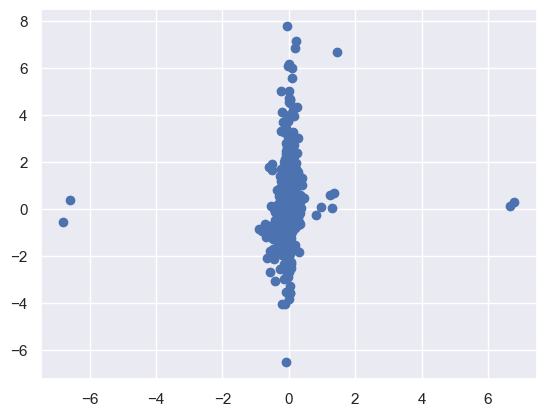

In [159]:

#cols_keep = select_columns(X_train_augmented,y_train,size_features=50)
#0.0455
X_train_augmented_t = np.array(X_train_augmented)
X_test_augmented_t = np.array(X_test_augmented)


l1_lasso_model = CustomLinearModel(
    X=np.array(X_train_augmented_t), Y=np.array(y_train), regularization=0.0 , alpha= 1.2, optim = 'BFGS'
)

#l1_lasso_model = Lasso(alpha=0.01)
l1_lasso_model = KLIEP(l1_lasso_model, Xt=np.array(X_test_augmented), kernel="rbf", gamma=[0.01], random_state=0)

l1_lasso_model.fit(np.array(X_train_augmented_t), np.array(y_train))

y_pred = l1_lasso_model.predict(X_train_augmented_t)
print(my_custom_loss_func(y_pred,y_train))
#print(list(zip(X_train_augmented.columns,l1_lasso_model.coef_)))

plt.scatter(y_pred,y_train)


In [160]:
#X_train_m, X_val_m, y_train_m, y_val_m = train_test_split(X_train_augmented, y_train, test_size=0.05,random_state=0,stratify=X_train_COUNTRY)
#X_train_m, X_val_m, y_train_m, y_val_m = train_test_split(X_train_m, y_train_m, test_size=0.2,random_state=1, stratify=y_train_m>0)

In [161]:
import lightgbm as lgbm
from optuna.integration import LightGBMPruningCallback
import optuna  # pip install optuna
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error
def objective(trial, X, y):
    param_grid = {
        # "device_type": trial.suggest_categorical("device_type", ['gpu']),
        #'boosting_type': 'dart',
        "n_estimators": trial.suggest_categorical("n_estimators", [50]),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.03),
        "num_leaves": trial.suggest_int("num_leaves", 20, 2000, step=10),
        "max_depth": trial.suggest_int("max_depth", 3, 6),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 1000, step=10),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 10, step=1),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 10, step=1),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 2),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.1
        ),
    }

    cv = KFold(n_splits=5, shuffle=True, random_state=1121218)

    cv_scores = np.zeros(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        
        X_train, X_test_m = X[train_idx,:], X[test_idx,:]
        y_train, y_test_m = y[train_idx], y[test_idx]
      
        
        model = lgbm.LGBMRegressor(objective="regression", **param_grid)
        
        model.fit(
            X_train,
            y_train,
            eval_set=[(np.array(X_val_m), np.array(y_val_m))],
            eval_metric='mae',
            early_stopping_rounds=10,
            callbacks=[
                LightGBMPruningCallback(trial, "l2")
            ],  # Add a pruning callback
        )
        preds = model.predict(X_test_m)
        cv_scores[idx] = 1 - my_custom_loss_func(np.array(y_test_m), preds)
       

    return np.mean(cv_scores)

In [162]:
'''
study = optuna.create_study(direction="minimize", study_name="LGBM Regressor")
func = lambda trial: objective(trial, np.array(X_train_m), np.array(y_train_m))
study.optimize(func, n_trials=20)

print(f"\tBest value (rmse): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")
'''

'\nstudy = optuna.create_study(direction="minimize", study_name="LGBM Regressor")\nfunc = lambda trial: objective(trial, np.array(X_train_m), np.array(y_train_m))\nstudy.optimize(func, n_trials=20)\n\nprint(f"\tBest value (rmse): {study.best_value:.5f}")\nprint(f"\tBest params:")\n\nfor key, value in study.best_params.items():\n    print(f"\t\t{key}: {value}")\n'

In [163]:
#study.best_params

In [164]:
'''

lgbm_parameters ={
 'n_estimators': 100,
 'learning_rate': 0.02683122408264061,
 'num_leaves': 1400,
 'max_depth': 3,
 'min_data_in_leaf': 220,
 'lambda_l1': 10,
 'lambda_l2': 10,
 'min_gain_to_split': 0.5916133975272007,
 'bagging_fraction': 0.8,
 'bagging_freq': 1,
 'feature_fraction': 0.4}

model = lgbm.LGBMRegressor(objective="regression", **lgbm_parameters)
model.fit(
    X_train_m,
    y_train_m,
    eval_set=[(X_val_m,y_val_m)],
    eval_metric='mae',
    early_stopping_rounds=10
)

#model = CustomLinearModel()#XGBRegressor(**{'colsample_bytree': 0.6655392754230048, 'gamma': 4.198875359789924, 'max_depth': 17, 'min_child_weight': 1.0, 'reg_alpha': 57.0, 'reg_lambda': 0.16332305739873})
#model.fit(X_train_merge,y_train_merge)
'''

'\n\nlgbm_parameters ={\n \'n_estimators\': 100,\n \'learning_rate\': 0.02683122408264061,\n \'num_leaves\': 1400,\n \'max_depth\': 3,\n \'min_data_in_leaf\': 220,\n \'lambda_l1\': 10,\n \'lambda_l2\': 10,\n \'min_gain_to_split\': 0.5916133975272007,\n \'bagging_fraction\': 0.8,\n \'bagging_freq\': 1,\n \'feature_fraction\': 0.4}\n\nmodel = lgbm.LGBMRegressor(objective="regression", **lgbm_parameters)\nmodel.fit(\n    X_train_m,\n    y_train_m,\n    eval_set=[(X_val_m,y_val_m)],\n    eval_metric=\'mae\',\n    early_stopping_rounds=10\n)\n\n#model = CustomLinearModel()#XGBRegressor(**{\'colsample_bytree\': 0.6655392754230048, \'gamma\': 4.198875359789924, \'max_depth\': 17, \'min_child_weight\': 1.0, \'reg_alpha\': 57.0, \'reg_lambda\': 0.16332305739873})\n#model.fit(X_train_merge,y_train_merge)\n'

In [165]:
#l = dict(zip(X_train_m.columns,model.feature_importances_))
#plt.barh(list(l.keys()),list(l.values()))

In [166]:
'''
l = dict(sorted(l.items(), key=lambda x: -x[1]))
list({k: v for k, v in l.items() if v>0})
'''

'\nl = dict(sorted(l.items(), key=lambda x: -x[1]))\nlist({k: v for k, v in l.items() if v>0})\n'

In [167]:
'''
y_pred = model.predict(X_train_m)
print('train', my_custom_loss_func((y_pred),np.array(y_train_m)))

y_pred = model.predict(X_val_m)
print('val', my_custom_loss_func((y_pred),np.array(y_val_m)))
'''

"\ny_pred = model.predict(X_train_m)\nprint('train', my_custom_loss_func((y_pred),np.array(y_train_m)))\n\ny_pred = model.predict(X_val_m)\nprint('val', my_custom_loss_func((y_pred),np.array(y_val_m)))\n"

In [168]:
l1_lasso_model.coef_

AttributeError: 'KLIEP' object has no attribute 'coef_'

In [ ]:
l = list(zip(X_train_augmented,l1_lasso_model.coef_))
l

[('DE_CONSUMPTION_RENEWABLE', -0.07354491225610879),
 ('DE_NET_EXPORT', -0.044651694123544236),
 ('COUNTRY DE_RESIDUAL_LOAD', 0.08791405237927112),
 ('DE_CONSUMPTION_RENEWABLE FR_CONSUMPTION_RENEWABLE', -0.022910515334029106),
 ('COUNTRY FR_NEED_RATIO_3', 0.00218242165978183),
 ('COUNTRY DE_HYDRO', 0.008660587822391538),
 ('FR_SOLAR DE_NEED_RATIO', 0.0015045120514741042),
 ('FR_TEMP DE_FLOW_COAL', -0.00826370698738817),
 ('DE_HYDRO^2', 0.005408194804553422),
 ('DE_CONSUMPTION_RENEWABLE FR_NEED_RATIO_1', -0.02499413626038973),
 ('FR_SOLAR DE_NEED_RATIO_3', 0.001247615401813319)]

In [ ]:
np.sum(l1_lasso_model.coef_!= 0) 

11

In [ ]:

l = list(zip(X_train_augmented.columns,l1_lasso_model.coef_))
keep = []
for i in l:
    if(i[1]!=0):
        keep.append(i[0])
keep


['DE_CONSUMPTION_RENEWABLE',
 'DE_NET_EXPORT',
 'COUNTRY DE_RESIDUAL_LOAD',
 'DE_CONSUMPTION_RENEWABLE FR_CONSUMPTION_RENEWABLE',
 'COUNTRY FR_NEED_RATIO_3',
 'COUNTRY DE_HYDRO',
 'FR_SOLAR DE_NEED_RATIO',
 'FR_TEMP DE_FLOW_COAL',
 'DE_HYDRO^2',
 'DE_CONSUMPTION_RENEWABLE FR_NEED_RATIO_1',
 'FR_SOLAR DE_NEED_RATIO_3']

In [ ]:

#0.0185
lasso_parameters = {
'alpha': np.arange(1, 2, 0.05),
'regularization': np.arange(0, 0.1, 0.005)
}

params = []
score = []
#for alpha in lasso_parameters['alpha']:
alpha = 1.2

for regularization in lasso_parameters['regularization']:
    model = CustomLinearModel(alpha = alpha, regularization=regularization, optim = 'BFGS')
    #model = Lasso(alpha = regularization)
    model = KLIEP(model, Xt=X_test_augmented, kernel="rbf", gamma=[0.01], random_state=0,verbose=0)
    #model.fit(X_train_augmented_t, y_train)
    params.append({'alpha':1.2,'regularization':regularization})
    s = evaluate_model_mean(X_train_augmented,y_train,model, stratify = X_train_COUNTRY,  state = 20, test_size=0.3)
    print(alpha, regularization, s)#, np.sum(model.coef_!=0))
    score.append(s)


1.2 0.0 [0.23806946]


KeyboardInterrupt: 

In [ ]:
'''
score = np.array(score)
plt.plot(score[:,0],label = 'all')
plt.plot(score[:,1],label='FR')
plt.plot(score[:,2],label ='DE')
plt.legend()
plt.plot()
'''

"\nscore = np.array(score)\nplt.plot(score[:,0],label = 'all')\nplt.plot(score[:,1],label='FR')\nplt.plot(score[:,2],label ='DE')\nplt.legend()\nplt.plot()\n"

In [ ]:
#l1_lasso_model = CustomLinearModel(alpha = 1.2, regularization = 0.0169)
#print(evaluate_model_mean(np.array(X_train), y_train, l1_lasso_model, test_size=0.33, loss = my_custom_loss_func, state = 100))
#l1_lasso_model.fit(X_train,y_train)
y_predict = model.predict(np.array(X_test_augmented))

In [ ]:
sub = pd.DataFrame()
sub['ID'] = id_test
sub['TARGET'] = y_predict
sub.to_csv("submissions/best_mape_augmented_3.csv",index=False)

In [ ]:
sub

,ID,TARGET
446,1626,-0.001026
231,410,0.005704
570,562,0.171127
120,1778,0.106062
491,1966,0.051121
...,...,...
556,452,-0.021003
89,1668,-0.014898
341,1486,0.080879
321,270,0.099224


In [ ]:
y_best = pd.read_csv("submissions/best_models/best_mape_augmented_3.csv")
test = pd.merge(sub,y_best,on='ID')
test.corr()

,ID,TARGET_x,TARGET_y
ID,1.000000,-0.215268,0.112504
TARGET_x,-0.215268,1.000000,0.652887
TARGET_y,0.112504,0.652887,1.000000


In [ ]:
test.cov()

,ID,TARGET_x,TARGET_y
ID,391499.374770,-7.857542,13.063124
TARGET_x,-7.857542,0.003403,0.007068
TARGET_y,13.063124,0.007068,0.034437
